In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns
import cartopy as ccrs
import cartopy.crs as ccrs

from tqdm import tqdm
import swifter

from osgeo import ogr, osr
from joblib import Parallel, delayed

tqdm.pandas()
import xarray as xr
from global_land_mask import globe
import geopandas as gpd

from datetime import date
today_date = date.today().strftime("%b_%d").lower()

In [2]:
# Keep only Duplicates

# loc_df_duplicates = loc_df[loc_df.duplicated(subset=['lat_long'], keep=False)]
# loc_df_duplicates.sort_values(by=['latitude', 'longitude'], inplace=True)
# print(len(loc_df_duplicates))
# loc_df_duplicates.tail(50)

In [2]:
# Species dictionay

species_name_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv')

dict_species_name = species_name_df.set_index('common_name').to_dict()['scientific_name']

In [55]:
# shapefilename = '/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp'
shapefilename = '/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroRIVERS_v10_na_shp/HydroRIVERS_v10_na.shp'
shapefilename = '/mnt/c/Users/imrit/Downloads/Shapefiles/Canada_provinces/lpr_000b16a_e.shp'

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

ds = ogr.Open(shapefilename)
layer = ds.GetLayer()
srs = layer.GetSpatialRef()

def get_zone(lat,lon):
    """
    Calculates local zone (1-60) based on longitude
    """
    lon180 = (lon + 180) % 360 - 180
    zone = int(np.ceil((lon180 + 180) / 6))
    return zone

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def convert_to_utm(lat,lon, zone=None, ellps='WGS84',inverse=False,**kwargs):
    """
    Converts from lat, lon to local UTM projection in metres
    zone (optional) : integer (between 1 and 60)
    Returns tuple of x,y coordinate
    """    

    if zone is None:
        zone = get_zone(lat,lon)

    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)
    
    target = osr.SpatialReference()
    if lat >= 0:
        target.ImportFromEPSG(int('326{}'.format(zone)))
    else:
        target.ImportFromEPSG(int('327{}'.format(zone)))

    if inverse:
        transform = osr.CoordinateTransformation(target, source)
    #    point = ogr.CreateGeometryFromWkt("POINT ({} {})".format(lon,lat))
    else:
        transform = osr.CoordinateTransformation(source, target)

    # Note that proper conversion here expects POINT as lat,lon
    point = ogr.CreateGeometryFromWkt("POINT ({} {})".format(lat,lon))
        
    point.Transform(transform)

    return point.GetX(),point.GetY()

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def draw_circle(lat,lon, radius=1,polygon=True): # km):
    zone = get_zone(lat,lon)

    # convert to local UTM (in metres)
    x0, y0 = convert_to_utm(lat,lon,zone=zone)

    # find radius of circle in metres
    r = radius * 1000
    phi = np.linspace(0, np.pi * 2,20)
    x = x0 + r * np.cos(phi)
    y = y0 + r * np.sin(phi)
    
    # convert back to latitude and longitude
    result = [convert_to_utm(i, j, zone = zone, inverse = True) for i,j in zip(x, y)]
    # return in Longitude, Latitude order to match HydroLAKES order of coordinates
    if polygon:
        result = 'POLYGON (({}))'.format(','.join(['{} {}'.format(j,i) for i, j in result]))
        return result
    else:
        return result

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def match2hydrolakes(lat,lon,dtol=1, displayOn=False, get_field = 'HYRIV_ID'):

# dtol is distance tolerance in km.
#    algorithm looks for any lakes that overlap with a circle of radius dtol drawn around point at (lat,lon)

# HydroLAKES coordinates are presented as (Lon,Lat) pairs
# coordinates must be (Lon, Lat) for HydroLAKES comparison
# Transform generally expects (lat, lon) order
# added setaxismapping to correct this

    wkt = 'POINT ({} {})'.format(lon,lat)
    point = ogr.CreateGeometryFromWkt(wkt)

    # create a circle around the point (these coordinate pairs are in lon,lat order)
    wkt = draw_circle(lat,lon,radius=dtol)
    
    # filter based on this circle
    layer.SetSpatialFilter(ogr.CreateGeometryFromWkt(wkt))

    # now calculate distance in metres =======
    #    Read in (lon, lat)
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)
    # This line reverses the expected input from (lat,lon) to (lon,lat) as appears in the HydroLAKES
    source.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)

    target = osr.SpatialReference()
    if lat >= 0:
        target.ImportFromEPSG(int('326{}'.format(get_zone(lat,lon))))
    else:
        target.ImportFromEPSG(int('327{}'.format(get_zone(lat,lon))))

    transform = osr.CoordinateTransformation(source, target)
    
    # transform point to new coordinate
    point.Transform(transform)
    
    hylak_dist = []
    hylak_id = []
    for feat in layer:
        geo = feat.GetGeometryRef()
        geo.Transform(transform)
        distance_to_lake = geo.Distance(point)
        hylak_id.append(feat.GetField('PREABBR'))
#         hylak_id.append(feat.GetField(get_field))
        hylak_dist.append(distance_to_lake)
        if distance_to_lake == 0:
            break

    # now find minimum distance
    result = [[i,j] for [i,j] in zip(hylak_dist, hylak_id)]

    # clean up 
    ds = None
    
    if len(result) == 0:
        return [np.nan, np.nan]
    else:
        return min(result)

In [ ]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/fish_community_ontario_1957_2017_v3_feb_9.csv')
loc_df = df[['waterbody_name', 'site_description', 'year', 'latitude', 'longitude', 'lat_long', 'surface_area', 
             'depth_max', 'secchi_depth', 'depth_mean']]
loc_df.head()

In [ ]:
loc_df_only = loc_df[['latitude', 'longitude', 'surface_area', 'depth_max', 'secchi_depth', 'depth_mean']]
print(len(loc_df_only))
loc_df_only.drop_duplicates(subset=['latitude', 'longitude'], inplace=True)
print(len(loc_df_only))
loc_df_only.head()

In [ ]:
sample_df = loc_df_only.sample(15)

In [ ]:
%%time
loc_df_only['hydro_dist'] = loc_df_only.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), axis=1)

In [ ]:
# loc_df_only['hylak_id'] = loc_df_only['hydro_dist'].split(',')[1]
display(loc_df_only.sample(10))

In [ ]:
%%time
sample_df['hydro_match'] = sample_df.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                           axis=1)
display(sample_df)

In [ ]:
sample_df[['hydro_dist','hydro_id']] = pd.DataFrame(sample_df['hydro_match'].tolist(), index= sample_df.index)
display(sample_df)

# All locations - Canada + USA

In [4]:
all_loc_df = pd.read_csv('/mnt/c/Users/imrit/Desktop/merged_dfs_actinopt_location_apr_14_2021.csv')
all_loc_df = all_loc_df[['latitude', 'longitude']]
all_loc_df = all_loc_df.loc[all_loc_df['longitude'] != all_loc_df['latitude']]
all_loc_df = all_loc_df.loc[(all_loc_df['latitude'] > 10) & (all_loc_df['latitude'] < 90) & 
                            (all_loc_df['longitude'] > -180) & (all_loc_df['longitude'] < -30)]
all_loc_df.drop_duplicates(inplace=True)
all_loc_df.reset_index(inplace=True)
print(len(all_loc_df))
display(all_loc_df.tail())

/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,3,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


949809


,index,latitude,longitude
949804,1885679,61.25564,-150.2909
949805,1885687,60.05600,-151.6631
949806,1885704,61.53409,-149.2670
949807,1885720,59.45795,-139.5714
949808,1885767,61.52089,-148.9544


In [ ]:
%%time
all_loc_df['hydro_dist'] = all_loc_df.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)

# all_loc_df['hydro_dist'] = all_loc_df.swifter.progress_apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
#                                                      axis=1)

In [7]:
def df_match_hydrolakes(df):
    df['hydro_dist'] = df.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), axis=1)
    return df

In [5]:
all_loc_1, all_loc_2, all_loc_3, all_loc_4 = np.array_split(all_loc_df, 4)

In [9]:
results = Parallel(n_jobs=4)(delayed(df_match_hydrolakes)(df) for df in [all_loc_1, all_loc_2, all_loc_3, all_loc_4])
print(results)

PicklingError: Could not pickle the task to send it to the workers.

In [10]:
%%time
all_loc_1['hydro_dist'] = all_loc_1.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)


CPU times: user 1h 26min 57s, sys: 20min 52s, total: 1h 47min 50s
Wall time: 1h 47min 50s


In [11]:
%%time
all_loc_2['hydro_dist'] = all_loc_2.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)


CPU times: user 1h 34min 55s, sys: 21min 50s, total: 1h 56min 45s
Wall time: 1h 56min 46s


In [12]:
%%time
all_loc_3['hydro_dist'] = all_loc_3.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)


CPU times: user 1h 35min 34s, sys: 20min 24s, total: 1h 55min 58s
Wall time: 1h 55min 37s


In [13]:
%%time
all_loc_4['hydro_dist'] = all_loc_4.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
                                                     axis=1)


CPU times: user 1h 32min 42s, sys: 21min 11s, total: 1h 53min 54s
Wall time: 1h 53min 43s


In [17]:
new_loc_dfs = pd.concat([all_loc_1, all_loc_2, all_loc_3, all_loc_4])
new_loc_dfs.rename(columns = {'hydro_dist': 'hydro_match'}, inplace=True)
new_loc_dfs[['hydro_dist', 'hydro_id']] = pd.DataFrame(new_loc_dfs['hydro_match'].tolist(), index= new_loc_dfs.index)
print(len(new_loc_dfs))
display(new_loc_dfs)

949809


,index,latitude,longitude,hydro_match,hydro_dist,hydro_id
0,0,45.095566,-74.434094,"[0.0, 754]",0.000000,754.0
1,1,45.029876,-73.332214,"[17.286849159692334, 64]",17.286849,64.0
2,2,45.015270,-71.632880,"[0.0, 109510]",0.000000,109510.0
3,3,45.098055,-71.656944,"[0.0, 1040479]",0.000000,1040479.0
4,4,45.029304,-71.907721,"[0.0, 109483]",0.000000,109483.0
...,...,...,...,...,...,...
949804,1885679,61.255640,-150.290900,"[nan, nan]",NaN,NaN
949805,1885687,60.056000,-151.663100,"[nan, nan]",NaN,NaN
949806,1885704,61.534090,-149.267000,"[nan, nan]",NaN,NaN
949807,1885720,59.457950,-139.571400,"[nan, nan]",NaN,NaN


In [19]:
new_loc_dfs.to_csv('/mnt/c/Users/imrit/Desktop/apr_15_fish_locs_hydro.csv', index=False)

# Save shapefile to csv

In [5]:
shapefile = gpd.read_file(shapefilename, ignore_geometry=True)
display(shapefile.head())

,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,1,Caspian Sea,Russia,Europe,SWBD,1,0,377001.91,15829.37,7.27,...,0.0,1,200.5,8110.642,107883.0,-29,-1.0,1404108.0,47.717708,45.591934
1,2,Great Bear,Canada,North America,CanVec,1,0,30450.64,5331.72,8.62,...,0.0,1,72.2,535.187,47577.7,145,-1.0,147665.4,-123.505546,65.138384
2,3,Great Slave,Canada,North America,CanVec,1,0,26734.29,9814.16,16.93,...,0.0,1,59.1,4350.692,4203.2,148,-1.0,995312.3,-117.617115,61.311727
3,4,Winnipeg,Canada,North America,CanVec,3,709,23923.04,4018.32,7.33,...,31790.0,1,11.9,2244.727,1464.3,215,-1.0,919611.5,-97.863542,53.696359
4,5,Superior,United States of America,North America,SWBD,1,0,81843.92,5248.36,5.18,...,0.0,1,146.7,2869.953,48410.3,179,-1.0,209219.5,-84.460547,46.468593


In [29]:
# shapefile = shapefile.loc[shapefile['Continent'] == 'North America']
# Len shapefile with only North America = 994072

In [7]:
shapefile.to_csv('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/hydrolakes_v10.csv', index=False)

# Hydro ids

# Nhi Alberta Hydro ID

In [40]:
nhi_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Homogenization/Data/alberta_lakes_resampled_max_5_species_cru.csv')
nhi_df.head()

,waterbody_name,year,grouped_lat,grouped_long,lat_long,esox_lucius,couesius_plumbeus,culaea_inconstans,catostomus_commersonii,chrosomus_neogaeus,...,mean_temp_dec,mean_temp_feb,mean_temp_jan,mean_temp_jul,mean_temp_jun,mean_temp_mar,mean_temp_may,mean_temp_nov,mean_temp_oct,mean_temp_sep
0,BOURQUE LAKE,1979,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-12.200000,-26.000000,-20.400000,17.300001,13.400001,-7.4,7.400000,-4.300000,5.1,10.500000
1,BOURQUE LAKE,1989,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-13.800000,-17.200001,-15.400001,17.300001,13.900001,-13.0,9.300000,-7.700000,3.1,9.400001
2,BOURQUE LAKE,2000,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-18.900000,-12.100000,-18.900000,16.200001,12.100000,-4.9,7.900000,-7.200000,3.5,8.700000
3,BOURQUE LAKE,2006,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-10.700000,-12.600000,-10.800000,17.400000,15.200000,-7.5,10.400001,-11.900001,1.4,10.500000
4,BOURQUE LAKE,2016,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-16.300001,-9.600000,-13.600000,16.400000,14.700000,-4.1,11.000000,-1.200000,1.6,9.600000


In [ ]:
new_loc_dfs[['hydro_dist', 'hydro_id']] = pd.DataFrame(new_loc_dfs['hydro_match'].tolist(), index= new_loc_dfs.index)
print(len(new_loc_dfs))

In [41]:
nhi_df['hydro_match'] = nhi_df.apply(lambda row: match2hydrolakes(row['grouped_lat'], row['grouped_long']), axis=1)

In [45]:
nhi_df[['hydro_dist', 'hydro_id']] = pd.DataFrame(nhi_df['hydro_match'].tolist(), index= nhi_df.index)
nhi_df.drop(columns=['hydro_dist'], inplace=True)
display(nhi_df.head())

,waterbody_name,year,grouped_lat,grouped_long,lat_long,esox_lucius,couesius_plumbeus,culaea_inconstans,catostomus_commersonii,chrosomus_neogaeus,...,mean_temp_jan,mean_temp_jul,mean_temp_jun,mean_temp_mar,mean_temp_may,mean_temp_nov,mean_temp_oct,mean_temp_sep,hydro_match,hydro_id
0,BOURQUE LAKE,1979,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-20.400000,17.300001,13.400001,-7.4,7.400000,-4.300000,5.1,10.500000,"[0.0, 81935]",81935.0
1,BOURQUE LAKE,1989,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-15.400001,17.300001,13.900001,-13.0,9.300000,-7.700000,3.1,9.400001,"[0.0, 81935]",81935.0
2,BOURQUE LAKE,2000,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-18.900000,16.200001,12.100000,-4.9,7.900000,-7.200000,3.5,8.700000,"[0.0, 81935]",81935.0
3,BOURQUE LAKE,2006,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-10.800000,17.400000,15.200000,-7.5,10.400001,-11.900001,1.4,10.500000,"[0.0, 81935]",81935.0
4,BOURQUE LAKE,2016,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,-13.600000,16.400000,14.700000,-4.1,11.000000,-1.200000,1.6,9.600000,"[0.0, 81935]",81935.0


In [50]:
nhi_cru_hydro = nhi_df.merge(hydrolakes_df, left_on=['hydro_id'], 
                       right_on=['Hylak_id'], how='left').drop(columns=['geometry'], axis=1)

display(nhi_cru_hydro.head())

,waterbody_name,year,grouped_lat,grouped_long,lat_long,esox_lucius,couesius_plumbeus,culaea_inconstans,catostomus_commersonii,chrosomus_neogaeus,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,BOURQUE LAKE,1979,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,0.0,3.0,7.8,0.1,4647.5,601.0,3.15,135.5,-110.542317,54.65604
1,BOURQUE LAKE,1989,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,0.0,3.0,7.8,0.1,4647.5,601.0,3.15,135.5,-110.542317,54.65604
2,BOURQUE LAKE,2000,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,0.0,3.0,7.8,0.1,4647.5,601.0,3.15,135.5,-110.542317,54.65604
3,BOURQUE LAKE,2006,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,0.0,3.0,7.8,0.1,4647.5,601.0,3.15,135.5,-110.542317,54.65604
4,BOURQUE LAKE,2016,54.673285,-110.546206,54.673_-110.546,1.0,NaN,NaN,1.0,NaN,...,0.0,3.0,7.8,0.1,4647.5,601.0,3.15,135.5,-110.542317,54.65604


In [51]:
nhi_cru_hydro.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Analysis/Homogenization/Data/alberta_lakes_resampled_max_5_species_cru_hydrolakes.csv', 
                     index=False)

# Hydro ID

In [2]:
%%time
hydrolakes_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/HydroLAKES_polys_v10_shp/hydrolakes_v10.csv')
display(hydrolakes_df.head())

<string>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,1,Caspian Sea,Russia,Europe,SWBD,1,0,377001.91,15829.37,7.27,...,0.0,1,200.5,8110.642,107883.0,-29,-1.0,1404108.0,47.717708,45.591934
1,2,Great Bear,Canada,North America,CanVec,1,0,30450.64,5331.72,8.62,...,0.0,1,72.2,535.187,47577.7,145,-1.0,147665.4,-123.505546,65.138384
2,3,Great Slave,Canada,North America,CanVec,1,0,26734.29,9814.16,16.93,...,0.0,1,59.1,4350.692,4203.2,148,-1.0,995312.3,-117.617115,61.311727
3,4,Winnipeg,Canada,North America,CanVec,3,709,23923.04,4018.32,7.33,...,31790.0,1,11.9,2244.727,1464.3,215,-1.0,919611.5,-97.863542,53.696359
4,5,Superior,United States of America,North America,SWBD,1,0,81843.92,5248.36,5.18,...,0.0,1,146.7,2869.953,48410.3,179,-1.0,209219.5,-84.460547,46.468593


CPU times: user 2.34 s, sys: 859 ms, total: 3.2 s
Wall time: 3.22 s


In [2]:
%%time
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/apr_23_fish_locs_hydro.csv')
# df['ocean'] = np.where(globe.is_ocean(df['latitude'], df['longitude']), 'YES', 'NO')
# df['hydro_id'] = np.where(df['hydro_dist'] > 1000, np.nan, df['hydro_id'])
display(df.head())

,latitude,longitude,hydro_match,hydro_dist,hydro_id,ocean,match2river,river_hydro_dist,river_hydro_id,hydro_waterbody
0,45.095566,-74.434094,"[0.0, 754]",0.000000,754.0,NO,NaN,NaN,NaN,lake
1,45.029876,-73.332214,"[17.286849159692334, 64]",17.286849,64.0,NO,NaN,NaN,NaN,lake
2,45.015270,-71.632880,"[0.0, 109510]",0.000000,109510.0,NO,NaN,NaN,NaN,lake
3,45.098055,-71.656944,"[0.0, 1040479]",0.000000,1040479.0,NO,NaN,NaN,NaN,lake
4,45.029304,-71.907721,"[0.0, 109483]",0.000000,109483.0,NO,NaN,NaN,NaN,lake


CPU times: user 1.75 s, sys: 875 ms, total: 2.62 s
Wall time: 2.83 s


In [35]:
df_hydro_id_only = df[['hydro_id', 'ocean']]
df_hydro_id_only.drop_duplicates(inplace=True)
print(len(df_hydro_id_only))

df_hydro_id_only = df_hydro_id_only.merge(hydrolakes_df, left_on='hydro_id', right_on=['Hylak_id'], how='left')
display(df_hydro_id_only.head())

print(df_hydro_id_only['Country'].value_counts())

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


32578


,hydro_id,ocean,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,754.0,NO,754.0,St. Francis,Canada,North America,CanVec,1.0,0.0,238.12,...,0.0,3.0,3.4,8060.090,1.2,43.0,0.62,781910.1,-74.168641,45.268507
1,64.0,NO,64.0,Champlain,Canada,North America,SWBD,1.0,0.0,1141.30,...,0.0,1.0,22.6,410.763,727.0,28.0,-1.00,21344.2,-73.334878,45.054564
2,109510.0,NO,109510.0,NaN,United States of America,North America,SWBD,1.0,0.0,2.18,...,0.0,3.0,9.5,1.004,238.9,390.0,5.36,45.1,-71.615685,45.011404
3,1040479.0,NO,1040479.0,NaN,Canada,North America,CanVec,1.0,0.0,0.12,...,0.0,3.0,4.4,0.024,264.9,472.0,4.68,1.1,-71.656121,45.097923
4,109483.0,NO,109483.0,NaN,Canada,North America,CanVec,1.0,0.0,1.88,...,0.0,3.0,11.9,0.275,937.0,469.0,7.33,12.3,-71.911476,45.034297


Canada                      18128
United States of America    14411
Mexico                         34
Guatemala                       2
Honduras                        1
Name: Country, dtype: int64


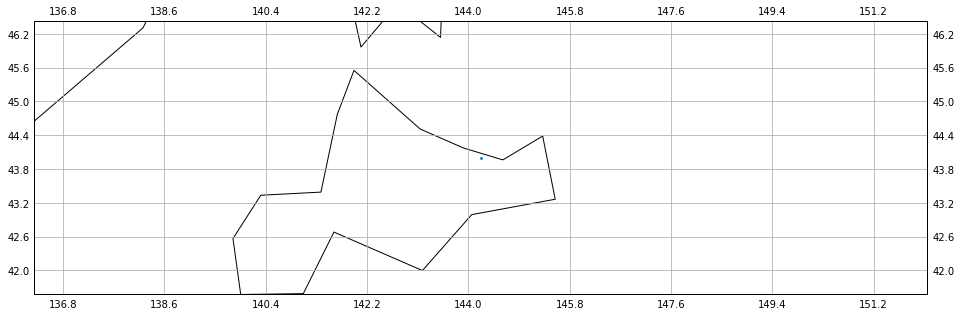

In [14]:
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_hydro_id_only.loc[df_hydro_id_only['Country'] == 'Japan']['Pour_long'], 
                df_hydro_id_only.loc[df_hydro_id_only['Country'] == 'Japan']['Pour_lat'], 
                transform=ccrs.PlateCarree(), palette='viridis', s=10)
# graph.legend()

graph.show()

In [5]:
# df_unmatched = df.loc[(df['hydro_id'].isna()) & (df['ocean'] == 'NO')]

# df_unmatched['match2river'] = df_unmatched.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude']), 
#                                                          axis=1)

# df_unmatched[['river_hydro_dist', 'river_hydro_id']] = pd.DataFrame(df_unmatched['match2river'].tolist(), 
#                                                                     index= df_unmatched.index)

# df_lake_river_hydro = df.merge(df_unmatched, how='left').drop('index', axis=1)

# df_lake_river_hydro['hydro_waterbody'] = np.where(~df_lake_river_hydro['hydro_id'].isna(), 'lake', np.nan)
# df_lake_river_hydro['hydro_waterbody'] = np.where(~df_lake_river_hydro['river_hydro_id'].isna(), 
#                                                   'river', df_lake_river_hydro['hydro_waterbody'])
# df_lake_river_hydro['hydro_waterbody'] = np.where(df_lake_river_hydro['ocean'] == 'YES', 
#                                                   'ocean', df_lake_river_hydro['hydro_waterbody'])

# display(df_lake_river_hydro)
# df_lake_river_hydro.to_csv('/mnt/c/Users/imrit/Desktop/apr_23_fish_locs_hydro.csv', index=False)

In [3]:
df['hydro_waterbody'].value_counts(dropna=False)

ocean    434760
river    244924
lake     159677
NaN      110448
Name: hydro_waterbody, dtype: int64

In [23]:
df_unidentified = df.loc[df['hydro_waterbody'].isna()]
df_unidentified.drop(columns=['hydro_match', 'hydro_dist', 'hydro_id',
       'ocean', 'match2river', 'river_hydro_dist', 'river_hydro_id',
       'hydro_waterbody'], inplace=True)

df_unidentified.to_csv('/mnt/c/Users/imrit/Desktop/apr_28_unidentified_locations.csv', index=False)

/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
df['hydro_waterbody'].replace(np.nan, 'unknown', inplace=True)

/home/arshad/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


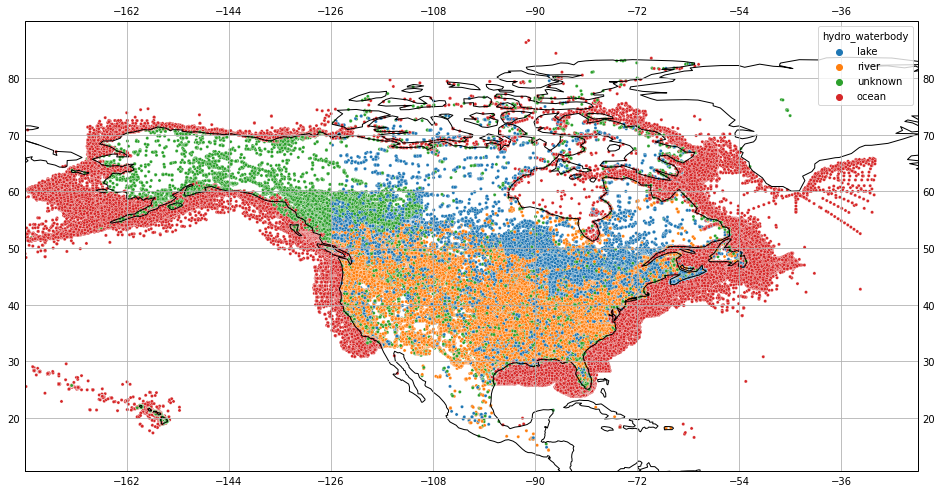

CPU times: user 1min 20s, sys: 3.83 s, total: 1min 23s
Wall time: 1min 25s


In [5]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df['longitude'], df['latitude'], hue = df['hydro_waterbody'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

In [30]:
df_lake_unknown = df.loc[df['hydro_waterbody'].isin(['lake', 'unknown'])]
df_lake_river = df.loc[df['hydro_waterbody'].isin(['lake', 'river'])]

/home/arshad/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


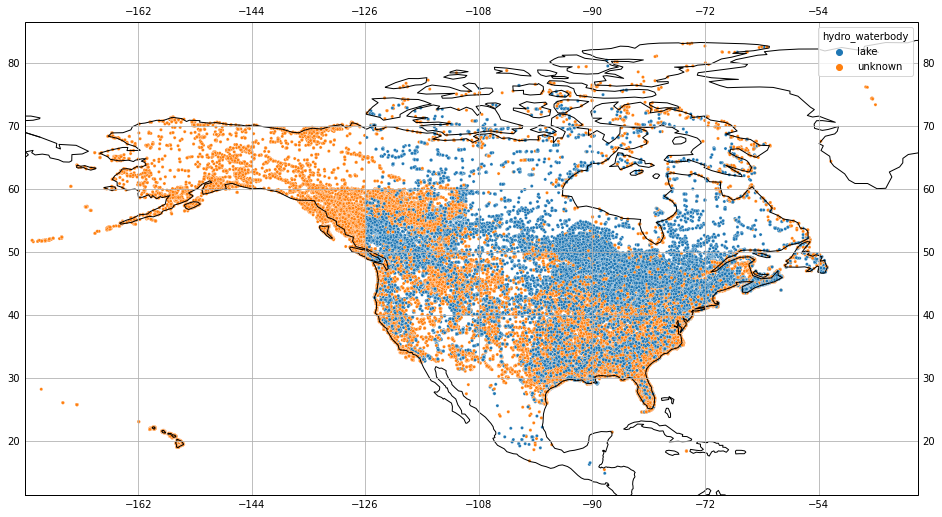

CPU times: user 15.7 s, sys: 906 ms, total: 16.6 s
Wall time: 16.2 s


In [31]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_lake_unknown['longitude'], df_lake_unknown['latitude'], hue = df_lake_unknown['hydro_waterbody'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

/home/arshad/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  inframe=inframe)
/home/arshad/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


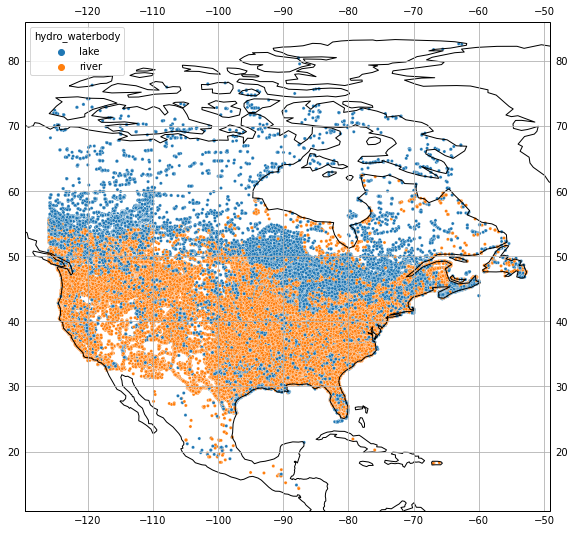

CPU times: user 27.6 s, sys: 1.86 s, total: 29.5 s
Wall time: 29.1 s


In [32]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_lake_river['longitude'], df_lake_river['latitude'], hue = df_lake_river['hydro_waterbody'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

# Hydrobasins

In [12]:
basins = gpd.read_file('/mnt/c/Users/imrit/Downloads/HydroLAKES_polys_v10/Hydrobasins/na_bas_15s_beta.shp', 
                             ignore_geometry=True)
display(basins.head())

,BASIN_ID,AREA_SQKM
0,1,0.1
1,2,0.2
2,3,0.2
3,4,0.2
4,5,0.2


In [7]:
len(canada_shape)

225822

In [8]:
canada_shape['PRUID'].unique()

array(['10', '60', '61', '62', '73', '12', '13', '24', '35', '46', '47',
       '48', '59', '11'], dtype=object)

In [9]:
canada_shape['RANK'].unique()

array([6, 5, 7, 2, 4, 3, 1])

In [4]:
today_date

'jun_17'

# Unidentified Location

In [7]:
df_unidentified = df.loc[df['hydro_waterbody'] == 'unknown']
df_unidentified.drop(columns=['hydro_match', 'hydro_dist', 'hydro_id',
       'ocean', 'match2river', 'river_hydro_dist', 'river_hydro_id',
       'hydro_waterbody'], inplace=True)
print(len(df_unidentified))
display(df_unidentified)

110448


/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,latitude,longitude
91,46.048779,-73.099504
96,45.875197,-73.278105
219,46.679123,-71.809516
230,47.021542,-70.676605
237,47.214796,-70.273828
...,...,...
949803,61.693130,-150.312200
949805,60.056000,-151.663100
949806,61.534090,-149.267000
949807,59.457950,-139.571400


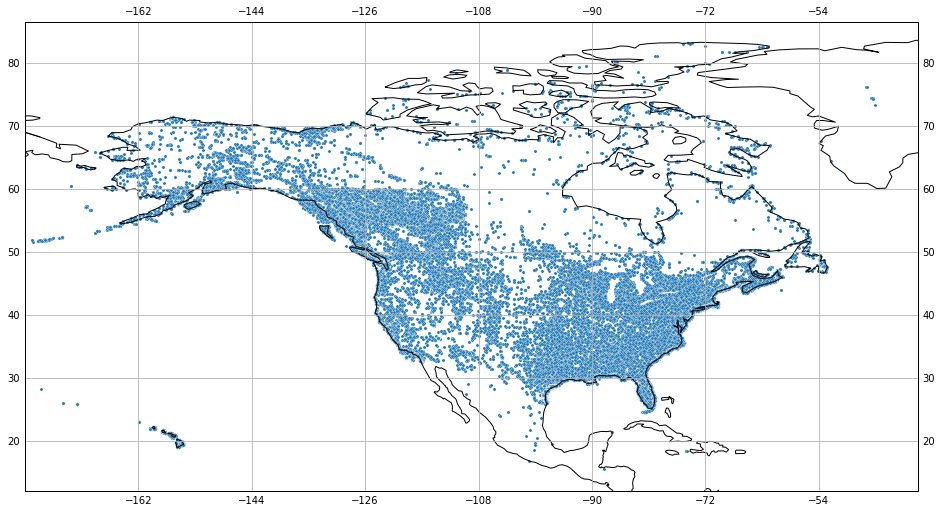

CPU times: user 1.12 s, sys: 406 ms, total: 1.53 s
Wall time: 957 ms


In [8]:
%%time
graph.figure(figsize=(16, 9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df_unidentified['longitude'], df_unidentified['latitude'],
                transform=ccrs.PlateCarree(), s=10)
# graph.legend()

graph.show()

In [39]:
import pgeocode
import geopandas
from geopy.geocoders import Nominatim
import reverse_geocoder as rg

In [42]:
rg.search((46.048779, -73.099504))

Loading formatted geocoded file...


[OrderedDict([('lat', '46.03336'),
              ('lon', '-73.11585'),
              ('name', 'Sorel-Tracy'),
              ('admin1', 'Quebec'),
              ('admin2', 'Monteregie'),
              ('cc', 'CA')])]

In [15]:
location = geolocator.reverse('46.048779'+","+'-73.099504')

In [45]:
df_unidentified['lat_long'] = df_unidentified['latitude'].astype(str) + ',' + df_unidentified['longitude'].astype(str)
df_unidentified

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,latitude,longitude,lat_long
91,46.048779,-73.099504,"46.048779,-73.09950400000001"
96,45.875197,-73.278105,"45.875197,-73.27810500000001"
219,46.679123,-71.809516,"46.679123,-71.809516"
230,47.021542,-70.676605,"47.021542,-70.67660500000001"
237,47.214796,-70.273828,"47.214796,-70.27382800000001"
...,...,...,...
949803,61.693130,-150.312200,"61.69313,-150.3122"
949805,60.056000,-151.663100,"60.056,-151.6631"
949806,61.534090,-149.267000,"61.53409,-149.267"
949807,59.457950,-139.571400,"59.45795,-139.5714"


In [37]:
geolocator.reverse(str(df_unidentified['lat_long']))

ValueError: Must be a coordinate pair or Point

In [25]:
%%time
df_unidentified['geopy'] = df_unidentified.swifter.apply(lambda row: geolocator.reverse(df_unidentified['lat_long']).raw['address'], 
                                                         axis=1)

ValueError: Must be a coordinate pair or Point

In [20]:
location.raw['address']['country']

'Canada'

In [22]:
str(df_unidentified['latitude']) +","+ str(df_unidentified['longitude'])

'91        46.048779\n96        45.875197\n219       46.679123\n230       47.021542\n237       47.214796\n            ...    \n949803    61.693130\n949805    60.056000\n949806    61.534090\n949807    59.457950\n949808    61.520890\nName: latitude, Length: 110448, dtype: float64,91        -73.099504\n96        -73.278105\n219       -71.809516\n230       -70.676605\n237       -70.273828\n             ...    \n949803   -150.312200\n949805   -151.663100\n949806   -149.267000\n949807   -139.571400\n949808   -148.954400\nName: longitude, Length: 110448, dtype: float64'

# Provinces and states shapefile

In [53]:
shapefile = gpd.read_file(shapefilename)
shapefile

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((8307365.589 2582136.711, 83083..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((8435711.754 1679935.966, 84358..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((8470851.646 1624745.011, 84710..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.460, 81762..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."
5,35,Ontario,Ontario,Ontario,Ont.,Ont.,"MULTIPOLYGON (((6378815.614 2295412.440, 63787..."
6,46,Manitoba,Manitoba,Manitoba,Man.,Man.,"MULTIPOLYGON (((6039656.509 2636304.343, 60396..."
7,47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,"POLYGON ((5248633.914 2767057.263, 5249285.640..."
8,48,Alberta,Alberta,Alberta,Alta.,Alb.,"POLYGON ((5228304.177 2767597.891, 5228098.463..."
9,59,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,"MULTIPOLYGON (((4018904.414 3410247.271, 40194..."


In [48]:
%%time
df_unidentified['province'] = df_unidentified.swifter.apply(lambda row: match2hydrolakes(row['latitude'], row['longitude'], 
                                                                                 get_field = 'PREABBR'), axis=1)

KeyboardInterrupt: 

In [54]:
sample_unidentified = df_unidentified[:100]
sample_unidentified

,latitude,longitude,lat_long
91,46.048779,-73.099504,"46.048779,-73.09950400000001"
96,45.875197,-73.278105,"45.875197,-73.27810500000001"
219,46.679123,-71.809516,"46.679123,-71.809516"
230,47.021542,-70.676605,"47.021542,-70.67660500000001"
237,47.214796,-70.273828,"47.214796,-70.27382800000001"
...,...,...,...
9819,51.036389,-115.746389,"51.0363889,-115.7463889"
9836,51.430278,-116.270833,"51.4302778,-116.2708333"
9844,51.505556,-116.006389,"51.5055556,-116.0063889"
9847,49.003333,-113.716111,"49.0033334,-113.7161111"


In [56]:
sample_unidentified['province'] = sample_unidentified.apply(lambda row: match2hydrolakes(row['latitude'], 
                                                                                         row['longitude']), axis=1)

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
sample_unidentified

,latitude,longitude,lat_long,province
91,46.048779,-73.099504,"46.048779,-73.09950400000001","[nan, nan]"
96,45.875197,-73.278105,"45.875197,-73.27810500000001","[nan, nan]"
219,46.679123,-71.809516,"46.679123,-71.809516","[nan, nan]"
230,47.021542,-70.676605,"47.021542,-70.67660500000001","[nan, nan]"
237,47.214796,-70.273828,"47.214796,-70.27382800000001","[nan, nan]"
...,...,...,...,...
9819,51.036389,-115.746389,"51.0363889,-115.7463889","[nan, nan]"
9836,51.430278,-116.270833,"51.4302778,-116.2708333","[nan, nan]"
9844,51.505556,-116.006389,"51.5055556,-116.0063889","[nan, nan]"
9847,49.003333,-113.716111,"49.0033334,-113.7161111","[nan, nan]"
